In [1]:
# pip install mistralai

In [2]:
from mistralai.client import MistralClient
from mistralai.models.chat_completion import ChatMessage
import os
import pandas as pd
from tqdm.auto import tqdm
import random

import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\amirm\anaconda3\envs\Thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
client = MistralClient(api_key=os.environ.get("MISTRAL_API_KEY", "kXOk6XpWsdExVlAgxQ4f2mRLrNldHSbh"))

In [4]:
def read_dataset(file_path):
    """Read the dataset from a CSV file."""
    return pd.read_csv(file_path, encoding='utf-8')

#------------------------------------------------------------

def generate_ai_text(title, text, language, domain, model, method):
    # Define word and token counts by language
    word_count_ranges = {
        'English': {'short': (70, 110), 'long': (300, 430)},
        'Spanish': {'short': (100, 140), 'long': (320, 570)},
        'French': {'short': (80, 110), 'long': (200, 550)}
    }
    token_counts = {
        'English': {'short': 120, 'long': 630},
        'Spanish': {'short': 150, 'long': 750},
        'French': {'short': 130, 'long': 680}    
    }

    # Select the appropriate counts for the given language
    short_range = word_count_ranges.get(language, {'short': (50, 100)})['short']
    long_range = word_count_ranges.get(language, {'long': (250, 500)})['long']
    max_tokens_short = token_counts.get(language, {'short': 130})['short']
    max_tokens_long = token_counts.get(language, {'long': 700})['long']

    if domain == "Wikipedia":
        if method == "Topic":
            max_tokens = max_tokens_short
            messages = [
                ChatMessage(
                    role="user",
                    content=(
                        f"You are tasked as a '{domain}' writer. Please craft a short text "
                        f"without a title, aiming for a total of {short_range[0]} to {short_range[1]} words. Your task "
                        f"is to compose a text in '{language}' about '{title}'."
                    )
                )
            ]
        elif method == "Continue":
            num_words = random.randint(20, 40)
            text_start = ' '.join(text.split()[:40][:num_words])
            max_tokens = max_tokens_short
            messages = [
                ChatMessage(
                    role="user",
                    content=(
                        f"You are tasked as a '{domain}' writer. Please craft a short text "
                        f"without a title, aiming for a total of {short_range[0]} to {short_range[1]} words. Your task "
                        f"is to Continue the text in '{language}' about '{title}', "
                        f"beginning with: '{text_start}'."
                    )
                )
            ]
    elif domain == "BBC":
        if method == "Topic":
            max_tokens = max_tokens_long
            messages = [
                ChatMessage(
                    role="user",
                    content=(
                        f"You are tasked as a '{domain}' writer. Please craft a text "
                        f"without a title, aiming for a total of {long_range[0]} to {long_range[1]} words. Your task "
                        f"is to compose a text in '{language}' about '{title}'."
                    )
                )
            ]
        elif method == "Continue":
            num_words = random.randint(20, 40)
            text_start = ' '.join(text.split()[:40][:num_words])
            max_tokens = max_tokens_long
            messages = [
                ChatMessage(
                    role="user",
                    content=(
                        f"You are tasked as a '{domain}' writer. Please craft a text "
                        f"without a title, aiming for a total of {long_range[0]} to {long_range[1]} words. Your task "
                        f"is to Continue the text in '{language}' about '{title}', "
                        f"beginning with: '{text_start}'."
                    )
                )
            ]

    chat_response = client.chat(
        model=model,
        messages=messages,
        max_tokens=max_tokens
    )

    # Extracting and formatting the response text
    text_content = chat_response.choices[0].message.content
    text_content = text_content.replace("\n\n", "\n").replace("\n", " ")
    
    return text_content

#------------------------------------------------------------

def update_dataset_with_ai_text(dataset, model, method):
    """Update the dataset with AI-generated text."""
    tqdm.pandas(desc="Generating AI Text")
    for index, row in tqdm(dataset.iterrows(), total=dataset.shape[0], desc="Progress"):
        if row['language'] in ['English', 'Spanish', 'French']:
            ai_text = generate_ai_text(row['title'], row['text'], row['language'], row['domain'], model, method)
            dataset.at[index, 'text'] = ai_text
            dataset.at[index, 'write_by'] = 'Ai'
            dataset.at[index, 'language'] = row['language'] 
            dataset.at[index, 'domain'] = row['domain']
            dataset.at[index, 'method'] = method
            dataset.at[index, 'LLM_model'] = model  
            dataset.at[index, 'label'] = 0
    return dataset

#------------------------------------------------------------

def save_new_dataset(dataset, new_file_path):
    """Save the updated dataset to a new CSV file."""
    dataset.to_csv(new_file_path, index=False, encoding='utf-8')

#------------------------------------------------------------



#### French BBC Continue

In [5]:
if __name__ == "__main__":
    file_path = 'C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Code/Gen_Ai_Text/French/Human_Text/BBC_French_Human_Continue.csv'
    model = "open-mistral-7b"
    method = "Continue"
    
    dataset = read_dataset(file_path)
    
    updated_dataset = update_dataset_with_ai_text(dataset, model, method)
    
    # Grabbing unique values for filename
    domain = updated_dataset['domain'].unique()[0]
    language = updated_dataset['language'].unique()[0]
    write_by = updated_dataset['write_by'].unique()[0]
    method = updated_dataset['method'].unique()[0]
    llm_model = updated_dataset['LLM_model'].unique()[0]
    
    # Constructing the new filename
    new_file_name = f"{domain}_{language}_{write_by}_{method}_({llm_model}).csv"
    new_file_path = os.path.join('C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Code/Gen_Ai_Text/French/Ai_Text_Mistral7B', new_file_name)
    
    # Saving the updated dataset
    save_new_dataset(updated_dataset, new_file_path)

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\amirm\AppData\Local\Temp\ipykernel_28316\4088267718.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Continue' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataset.at[index, 'method'] = method
C:\Users\amirm\AppData\Local\Temp\ipykernel_28316\4088267718.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'open-mistral-7b' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataset.at[index, 'LLM_model'] = model
Progress: 100%|██████████| 1000/1000 [2:17:00<00:00,  8.22s/it] 


In [6]:
# Paths to the CSV files
csv_path_1 = 'C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Code/Gen_Ai_Text/French/Human_Text/BBC_French_Human_Continue.csv'
csv_path_2 = 'C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Code/Gen_Ai_Text/French/Ai_Text_Mistral7B/BBC_French_Ai_Continue_(open-mistral-7b).csv'

# Reading the CSV files
df_1 = pd.read_csv(csv_path_1, encoding='utf-8')
df_2 = pd.read_csv(csv_path_2, encoding='utf-8')

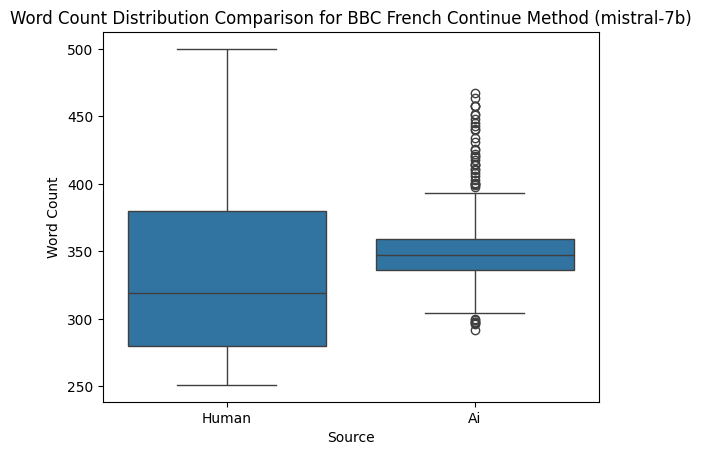

In [7]:
# Calculate the word count for each 'text' in both dataframes
df_1['word_count'] = df_1['text'].apply(lambda x: len(str(x).split()))
df_2['word_count'] = df_2['text'].apply(lambda x: len(str(x).split()))

# Combine both DataFrames into one for easier plotting
df_1['Source'] = 'Human'
df_2['Source'] = 'Ai'
combined_df = pd.concat([df_1, df_2])

# Plotting boxplots side by side
sns.boxplot(x='Source', y='word_count', data=combined_df)
plt.title('Word Count Distribution Comparison for BBC French Continue Method (mistral-7b)')
plt.xlabel('Source')
plt.ylabel('Word Count')

# You might want to adjust limits or other plot properties based on your data
plt.show()


#### French BBC Topic

In [9]:
if __name__ == "__main__":
    file_path = 'C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Code/Gen_Ai_Text/French/Human_Text/BBC_French_Human_Topic.csv'
    model = "open-mistral-7b"
    method = "Topic"
    
    dataset = read_dataset(file_path)
    
    updated_dataset = update_dataset_with_ai_text(dataset, model, method)
    
    # Grabbing unique values for filename
    domain = updated_dataset['domain'].unique()[0]
    language = updated_dataset['language'].unique()[0]
    write_by = updated_dataset['write_by'].unique()[0]
    method = updated_dataset['method'].unique()[0]
    llm_model = updated_dataset['LLM_model'].unique()[0]
    
    # Constructing the new filename
    new_file_name = f"{domain}_{language}_{write_by}_{method}_({llm_model}).csv"
    new_file_path = os.path.join('C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Code/Gen_Ai_Text/French/Ai_Text_Mistral7B', new_file_name)
    
    # Saving the updated dataset
    save_new_dataset(updated_dataset, new_file_path)

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\amirm\AppData\Local\Temp\ipykernel_28316\4088267718.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Topic' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataset.at[index, 'method'] = method
C:\Users\amirm\AppData\Local\Temp\ipykernel_28316\4088267718.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'open-mistral-7b' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataset.at[index, 'LLM_model'] = model
Progress: 100%|██████████| 1000/1000 [2:17:01<00:00,  8.22s/it] 


In [10]:
# Paths to the CSV files
csv_path_1 = 'C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Code/Gen_Ai_Text/French/Human_Text/BBC_French_Human_Topic.csv'
csv_path_2 = 'C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Code/Gen_Ai_Text/French/Ai_Text_Mistral7B/BBC_French_Ai_Topic_(open-mistral-7b).csv'

# Reading the CSV files
df_1 = pd.read_csv(csv_path_1, encoding='utf-8')
df_2 = pd.read_csv(csv_path_2, encoding='utf-8')

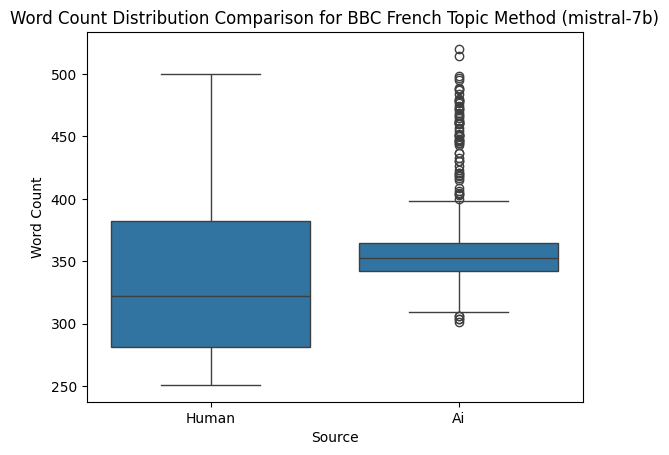

In [11]:
# Calculate the word count for each 'text' in both dataframes
df_1['word_count'] = df_1['text'].apply(lambda x: len(str(x).split()))
df_2['word_count'] = df_2['text'].apply(lambda x: len(str(x).split()))

# Combine both DataFrames into one for easier plotting
df_1['Source'] = 'Human'
df_2['Source'] = 'Ai'
combined_df = pd.concat([df_1, df_2])

# Plotting boxplots side by side
sns.boxplot(x='Source', y='word_count', data=combined_df)
plt.title('Word Count Distribution Comparison for BBC French Topic Method (mistral-7b)')
plt.xlabel('Source')
plt.ylabel('Word Count')

# You might want to adjust limits or other plot properties based on your data
plt.show()


#### French Wikipedia Continue

In [15]:
if __name__ == "__main__":
    file_path = 'C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Code/Gen_Ai_Text/French/Human_Text/Wikipedia_French_Human_Continue.csv'
    model = "open-mistral-7b"
    method = "Continue"
    
    dataset = read_dataset(file_path)
    
    updated_dataset = update_dataset_with_ai_text(dataset, model, method)
    
    # Grabbing unique values for filename
    domain = updated_dataset['domain'].unique()[0]
    language = updated_dataset['language'].unique()[0]
    write_by = updated_dataset['write_by'].unique()[0]
    method = updated_dataset['method'].unique()[0]
    llm_model = updated_dataset['LLM_model'].unique()[0]
    
    # Constructing the new filename
    new_file_name = f"{domain}_{language}_{write_by}_{method}_({llm_model}).csv"
    new_file_path = os.path.join('C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Code/Gen_Ai_Text/French/Ai_Text_Mistral7B', new_file_name)
    
    # Saving the updated dataset
    save_new_dataset(updated_dataset, new_file_path)

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\amirm\AppData\Local\Temp\ipykernel_28316\4088267718.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Continue' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataset.at[index, 'method'] = method
C:\Users\amirm\AppData\Local\Temp\ipykernel_28316\4088267718.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'open-mistral-7b' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataset.at[index, 'LLM_model'] = model
Progress: 100%|██████████| 1000/1000 [36:31<00:00,  2.19s/it]


In [16]:
# Paths to the CSV files
csv_path_1 = 'C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Code/Gen_Ai_Text/French/Human_Text/Wikipedia_French_Human_Continue.csv'
csv_path_2 = 'C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Code/Gen_Ai_Text/French/Ai_Text_Mistral7B/Wikipedia_French_Ai_Continue_(open-mistral-7b).csv'

# Reading the CSV files
df_1 = pd.read_csv(csv_path_1, encoding='utf-8')
df_2 = pd.read_csv(csv_path_2, encoding='utf-8')

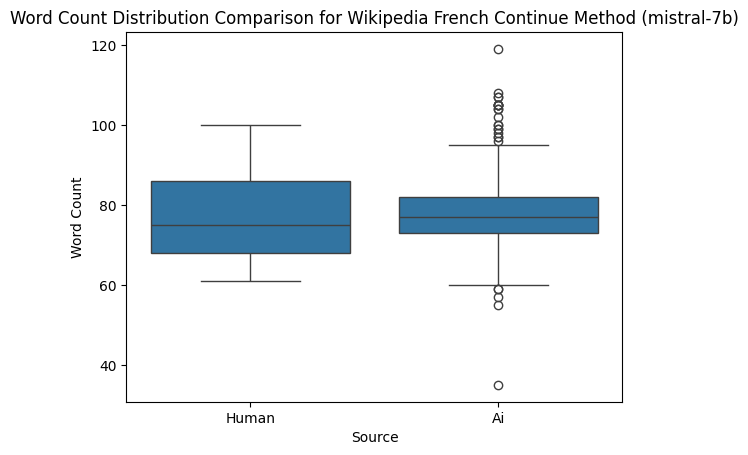

In [17]:
# Calculate the word count for each 'text' in both dataframes
df_1['word_count'] = df_1['text'].apply(lambda x: len(str(x).split()))
df_2['word_count'] = df_2['text'].apply(lambda x: len(str(x).split()))

# Combine both DataFrames into one for easier plotting
df_1['Source'] = 'Human'
df_2['Source'] = 'Ai'
combined_df = pd.concat([df_1, df_2])

# Plotting boxplots side by side
sns.boxplot(x='Source', y='word_count', data=combined_df)
plt.title('Word Count Distribution Comparison for Wikipedia French Continue Method (mistral-7b)')
plt.xlabel('Source')
plt.ylabel('Word Count')

# You might want to adjust limits or other plot properties based on your data
plt.show()


#### French Wikipedia Topic

In [18]:
if __name__ == "__main__":
    file_path = 'C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Code/Gen_Ai_Text/French/Human_Text/Wikipedia_French_Human_Topic.csv'
    model = "open-mistral-7b"
    method = "Topic"
    
    dataset = read_dataset(file_path)
    
    updated_dataset = update_dataset_with_ai_text(dataset, model, method)
    
    # Grabbing unique values for filename
    domain = updated_dataset['domain'].unique()[0]
    language = updated_dataset['language'].unique()[0]
    write_by = updated_dataset['write_by'].unique()[0]
    method = updated_dataset['method'].unique()[0]
    llm_model = updated_dataset['LLM_model'].unique()[0]
    
    # Constructing the new filename
    new_file_name = f"{domain}_{language}_{write_by}_{method}_({llm_model}).csv"
    new_file_path = os.path.join('C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Code/Gen_Ai_Text/French/Ai_Text_Mistral7B', new_file_name)
    
    # Saving the updated dataset
    save_new_dataset(updated_dataset, new_file_path)

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\amirm\AppData\Local\Temp\ipykernel_28316\4088267718.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Topic' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataset.at[index, 'method'] = method
C:\Users\amirm\AppData\Local\Temp\ipykernel_28316\4088267718.py:108: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'open-mistral-7b' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataset.at[index, 'LLM_model'] = model
Progress: 100%|██████████| 1000/1000 [36:15<00:00,  2.18s/it]


In [19]:
# Paths to the CSV files
csv_path_1 = 'C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Code/Gen_Ai_Text/French/Human_Text/Wikipedia_French_Human_Topic.csv'
csv_path_2 = 'C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Code/Gen_Ai_Text/French/Ai_Text_Mistral7B/Wikipedia_French_Ai_Topic_(open-mistral-7b).csv'

# Reading the CSV files
df_1 = pd.read_csv(csv_path_1, encoding='utf-8')
df_2 = pd.read_csv(csv_path_2, encoding='utf-8')

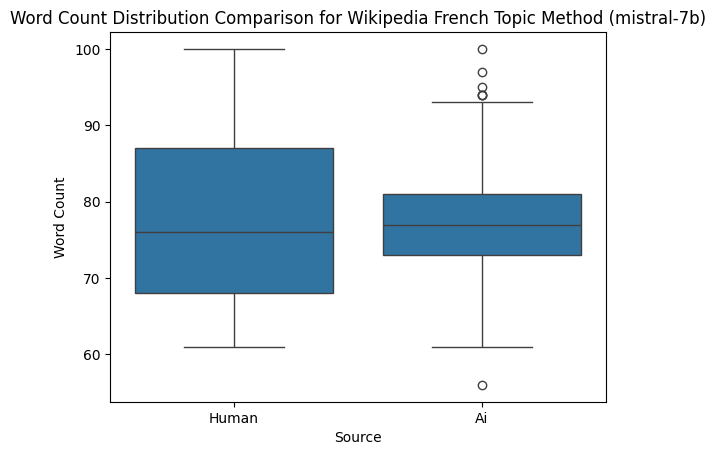

In [20]:
# Calculate the word count for each 'text' in both dataframes
df_1['word_count'] = df_1['text'].apply(lambda x: len(str(x).split()))
df_2['word_count'] = df_2['text'].apply(lambda x: len(str(x).split()))

# Combine both DataFrames into one for easier plotting
df_1['Source'] = 'Human'
df_2['Source'] = 'Ai'
combined_df = pd.concat([df_1, df_2])

# Plotting boxplots side by side
sns.boxplot(x='Source', y='word_count', data=combined_df)
plt.title('Word Count Distribution Comparison for Wikipedia French Topic Method (mistral-7b)')
plt.xlabel('Source')
plt.ylabel('Word Count')

# You might want to adjust limits or other plot properties based on your data
plt.show()
